In [1]:
import torch
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
from collections import defaultdict
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report



## Metrics

In [183]:
thresh_metrics = {}
thresh_mean = {}
thresh_stdev = {}

for thresh in ['1.0', '0.85', '0.75', '0.65', 'baseline']:
    thresh_metrics[thresh] = {'Precision': [], 'Recall': [], 'Accuracy': [], 'F1': []}
    thresh_mean[thresh] = {'Precision': [], 'Recall': [], 'Accuracy': [], 'F1': []}
    thresh_stdev[thresh] = {'Precision': [], 'Recall': [], 'Accuracy': [], 'F1': []}
    metrics = pickle.load(open(f'nan_test_metrics_{thresh}.pkl', 'rb'))
    # print(metrics[0]['pred'])
    
    for fold in range(5):
        thresh_metrics[thresh]['Precision'].append(precision_score(metrics[fold]['target'], metrics[fold]['pred'] , average='weighted') )
        thresh_metrics[thresh]['Recall'].append( recall_score(metrics[fold]['target'], metrics[fold]['pred'] , average='weighted') )
        thresh_metrics[thresh]['F1'].append( f1_score(metrics[fold]['target'], metrics[fold]['pred'] , average='weighted') )
        thresh_metrics[thresh]['Accuracy'].append( accuracy_score(metrics[fold]['target'], metrics[fold]['pred'] ) )


    thresh_mean[thresh]['Precision'] = np.mean( thresh_metrics[thresh]['Precision'] )
    thresh_stdev[thresh]['Precision'] = np.std( thresh_metrics[thresh]['Precision'] )
    thresh_mean[thresh]['Recall'] = np.mean( thresh_metrics[thresh]['Recall'] )
    thresh_stdev[thresh]['Recall'] = np.std( thresh_metrics[thresh]['Recall'] )
    thresh_mean[thresh]['F1'] = np.mean( thresh_metrics[thresh]['F1'] )
    thresh_stdev[thresh]['F1'] = np.std( thresh_metrics[thresh]['F1'] )
    thresh_mean[thresh]['Accuracy'] = np.mean( thresh_metrics[thresh]['Accuracy'] )
    thresh_stdev[thresh]['Accuracy'] = np.std( thresh_metrics[thresh]['Accuracy'] )

thresh_stdev = pd.DataFrame(thresh_stdev)
thresh_stdev

/home/inesgp/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/inesgp/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/inesgp/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/inesgp/.local/lib/python3.11/site-packag

,1.0,0.85,0.75,0.65,baseline
Precision,0.001297,0.001767,0.002565,0.004105,0.001443
Recall,0.001319,0.001817,0.002676,0.005070,0.001449
Accuracy,0.001319,0.001817,0.002676,0.005070,0.001449
F1,0.001320,0.001818,0.002712,0.005211,0.001450


In [184]:
thresh_mean = pd.DataFrame(thresh_mean)
thresh_mean

,1.0,0.85,0.75,0.65,baseline
Precision,0.988671,0.988585,0.981473,0.931717,0.991032
Recall,0.988600,0.988500,0.981300,0.926500,0.991000
Accuracy,0.988600,0.988500,0.981300,0.926500,0.991000
F1,0.988604,0.988499,0.981282,0.926622,0.990999


## Skipped Conv

Threshold 1 Accuracy Mean 98.86 Standard Deviation 0.13
[98.85, 98.65, 98.8, 99.0, 99.0]
[0.00000000e+00 1.54284184e-01 4.08163265e-06 0.00000000e+00]
Threshold 0.85 Accuracy Mean 98.85 Standard Deviation 0.18
[98.95, 98.55, 98.8, 99.1, 98.85]
[0.         0.2717352  0.00666327 0.        ]
Threshold 0.75 Accuracy Mean 98.13000000000001 Standard Deviation 0.27
[98.2, 97.6, 98.25, 98.3, 98.3]
[0.         0.35254133 0.0863449  0.        ]
Threshold 0.65 Accuracy Mean 92.65 Standard Deviation 0.51
[93.55, 92.0, 92.7, 92.55, 92.45]
[0.         0.55914337 0.2875449  0.0048    ]
Threshold 0.5 Accuracy Mean 19.82 Standard Deviation 0.63
[19.85, 18.7, 20.4, 19.7, 20.45]
[0.         0.74990051 0.78601429 0.40896667]


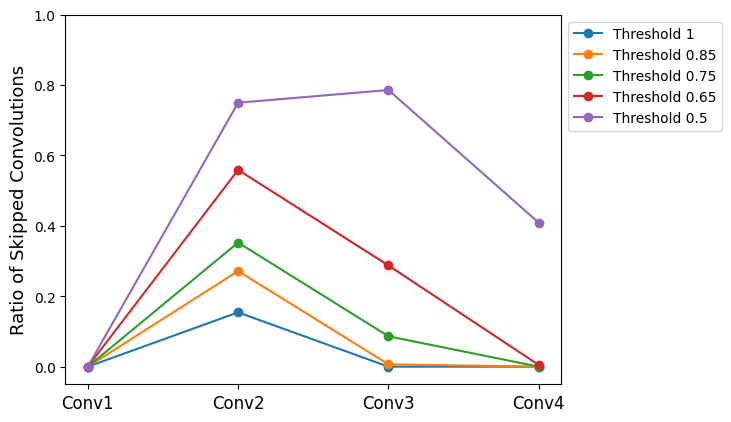

In [10]:
def parse_folds(file_path, conv_and_acc=True):
    # Initialize the nested result dictionary
    result = {}
    
    # Read the file
    with open(file_path, 'r') as file:
        text = file.read()
    
    # Split by folds
    folds = text.strip().split("Fold")
    for i, fold in enumerate(folds[1:], start=1):
        fold_key = f'fold{i}'
        lines = fold.strip().split("\n")
        fold_means = {}

        if conv_and_acc:
            conv_values = {'conv1': [], 'conv2': [], 'conv3': [], 'conv4': []}   
            # Extract convolution values
            for line in lines:
                if "Conv" in line:
                    key, value = line.split(":")
                    value = float(value.split()[0])  # Only take the first number
                    conv_values[key.strip().lower()].append(value)
        
            # Calculate averages for the convolution layers for this fold
            for key in conv_values:
                fold_means[key] = sum(conv_values[key]) / len(conv_values[key])
            
        # Extract accuracy
        accuracy = None
        if "Accuracy" in lines[-1]:
            if fold_key == 'fold5' and "Accuracy" in lines[-3]:
                text = lines[-3]
            else:
                text = lines[-1]

            accuracy = float(text.split("(")[1].split("%")[0])
            fold_means['accuracy'] = accuracy

        # Store the fold data in the result dictionary
        result[fold_key] = fold_means

    return result


# # Baseline
# file_path = f'slurm/mnist_test_kfold.out'  # Replace with the actual file path
# baseline_data = [x['accuracy'] for x in list(parse_folds(file_path, conv_and_acc=False).values())]
# print(f"Baseline Accuracy Mean {np.mean(baseline_data)} Standard Deviation {np.std(baseline_data):.2f}")
# print(baseline_data)

thresh_mnist = {}
for num, thresh in enumerate(['1', '0.85', '0.75', '0.65', '0.5' ]):

    thresh_mnist[thresh] = {}
    file_path = f'slurm/nan_mnist_test_{num}.out'  # Replace with the actual file path
    parsed_data = parse_folds(file_path)

    fold_skipconv = []
    acc_metric = []
    for fold in parsed_data:
        # print(fold, parsed_data[fold].values())
        fold_skipconv.append(list(parsed_data[fold].values())[:-1])
        acc_metric.append(list(parsed_data[fold].values())[-1])
        # plt.plot(list(parsed_data[fold].values())[1:-1], marker='o', label=f'Fold {fold}')

    print(f"Threshold {thresh} Accuracy Mean {np.mean(acc_metric)} Standard Deviation {np.std(acc_metric):.2f}")
    print(acc_metric)
    avg = np.mean( np.array(fold_skipconv) , axis=0)
    stdev = np.std( np.array(fold_skipconv) ,axis=0)
    print(avg)
    plt.plot(avg, marker='o', label=f'Threshold {thresh}')
    plt.fill_between(range(len( np.array(fold_skipconv)[0] )), avg - stdev, avg + stdev, alpha=0.3)
    plt.xticks(np.arange(4), ['Conv1', 'Conv2', 'Conv3', 'Conv4'], fontsize=12);

# plt.legend()
plt.ylim(-0.05,1)
plt.ylabel("Ratio of Skipped Convolutions", fontsize=13)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1));
# plt.title('Skipped Convolutions Averaged Across Folds');
plt.savefig('/home/inesgp/mnist/mnist_skipconv.pdf', format="pdf", bbox_inches="tight")


### No KFold Testing

In [69]:
thresh_mnist = {}

for num, thresh in enumerate(['0.85', '0.75', '0.65', ]):

    thresh_mnist[thresh] = {}

    # Open the file
    with open(f"slurm/nan_mnist_test_{num}.out", 'r') as f:
        # Initialize a defaultdict for storing values
        parsed_data = defaultdict(list)

        # Regex to find "ConvX: <value>" and "Accuracy <value>"
        conv_pattern = r"(Conv\d+):\s([\d.]+)"
        accuracy_pattern = r"Accuracy\s([\d.]+)"
        separator = True

        # Process each line in the file
        for row in f:
            # if 'Test set' in row and separator: 
            #     parsed_data_075 = dict(parsed_data)
            #     parsed_data = defaultdict(list)
            #     separator = False

            # Extract ConvX values
            for match in re.finditer(conv_pattern, row):
                key = match.group(1).lower()
                value = float(match.group(2))
                parsed_data[key].append(value)

            # Extract Accuracy values
            for match in re.finditer(accuracy_pattern, row):
                value = float(match.group(1))
                parsed_data['accuracy'].append(value)

    # Convert defaultdict to a regular dictionary
    parsed_data = dict(parsed_data)
    thresh_mnist[thresh] = parsed_data

    # Output the parsed data
    print(parsed_data)


{'conv1': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'conv2': [0.28265816326530613, 0.2867295918367347, 0.2820918367346939, 0.27910204081632656, 0.2873265306122449, 0.2648469387755102, 0.26113265306122446, 0.25978061224489796, 0.25060204081632653, 0.2630816326530612], 'conv3': [0.008816326530612244, 0.006959183673469388, 0.007714285714285714, 0.007816326530612245, 0.008183673469387755, 0.006142857142857143, 0.0059387755102040815, 0.005081632653061225, 0.003959183673469388, 0.006020408163265306], 'conv4': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'accuracy': [98.0, 98.2, 97.7, 98.7, 98.2, 99.6, 99.2, 99.8, 99.8, 99.3]}
{'conv1': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'conv2': [0.3638061224489796, 0.3678571428571429, 0.3635765306122449, 0.3615204081632653, 0.3678418367346939, 0.34564285714285714, 0.34154591836734693, 0.3396173469387755, 0.3310918367346939, 0.34291326530612243], 'conv3': [0.09257142857142857, 0.09820408163265307, 0.09285714285714286, 0.0911

Threshold 0.85 mean skipped convolutions ratio 9.28%
Threshold 0.75 mean skipped convolutions ratio 14.63%
Threshold 0.65 mean skipped convolutions ratio 28.38%


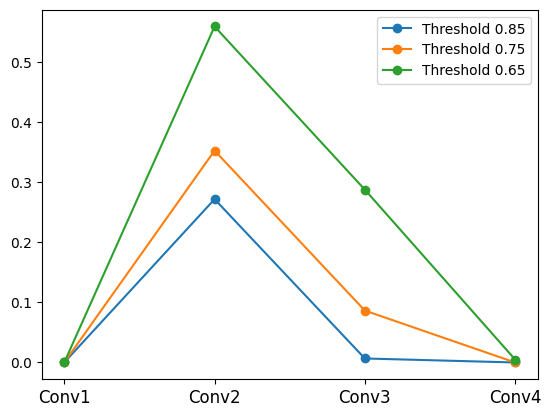

In [75]:
for num, thresh in enumerate(['0.85', '0.75', '0.65', ]):
    mean_val = []
    for k in thresh_mnist[thresh].keys():
        mean_val.append( np.array(thresh_mnist[thresh][k]).mean() )
    print(f"Threshold {thresh} mean skipped convolutions ratio {np.mean(mean_val[1:-1])*100:.2f}%")
    plt.plot(mean_val[:-1], marker='o', label=f'Threshold {thresh}')
    plt.xticks(np.arange(4), ['Conv1', 'Conv2', 'Conv3', 'Conv4'], fontsize=12)
plt.legend();


## NaN Pooling Embedding

* All random values from gaussian distribution centered at max val works \
**Probability of 0s occuring 0**
* Convolution threshold: 1.0, Pooling threshold: 3 --> Accuracy (single test batch): 98.4% --> Under 1% skipped conv
* Convolution threshold: 0.75, Pooling threshold: 3 --> Accuracy (single test batch): 98.2% --> Up to 30% skipped conv
* Convolution threshold: 0.6, Pooling threshold: 3 --> Accuracy (single test batch): 97.5% --> Didn't check skipped conv
* Convolution threshold: 0.5, Pooling threshold: 3 --> Accuracy (single test batch): 81.8% --> Up to 50% skipped conv

* Convolution threshold: 1.0, Pooling threshold: 2 --> Accuracy (single test batch): 98.5% --> Under 1% skipped conv
* Convolution threshold: 0.75, Pooling threshold: 2 --> Accuracy (single test batch): 98.2% --> Up to 30% skipped conv
* Convolution threshold: 0.5, Pooling threshold: 2 --> Accuracy (single test batch): 68.9% (inf loss) --> Up to 50% skipped conv

* Convolution threshold: 1.0, Pooling threshold: 1 --> Accuracy (single test batch): 98.1% --> Under 1% skipped conv
* Convolution threshold: 0.75, Pooling threshold: 1 --> Accuracy (single test batch): 97.5% (inf loss) --> Up to 30% skipped conv
* Convolution threshold: 0.5, Pooling threshold: 1 --> Accuracy (single test batch): 17.3% (inf loss) --> Didn't check skipped conv

**Probability of 0s occuring 0.3**
* Convolution threshold: 1.0, Pooling threshold: 1 --> Accuracy (single test batch): 2.8%
* Convolution threshold: 0.5, Pooling threshold: 1 --> Accuracy (single test batch): 5.2%
* Convolution threshold: 1.0, Pooling threshold: 2 --> Accuracy (single test batch): 4.8%

**Probability of 0s occuring 0.5**
* Convolution threshold: 1.0, Pooling threshold: 1 --> Accuracy (single test batch): 1.5%
* Convolution threshold: 1.0, Pooling threshold: 2 --> Accuracy (single test batch): 1.6%
* 

### Pool Threshold 3

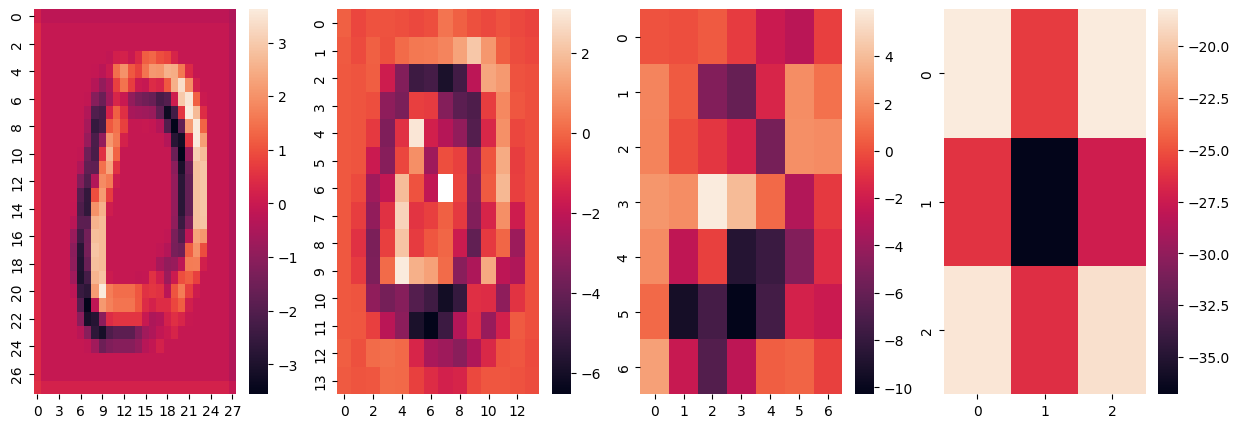

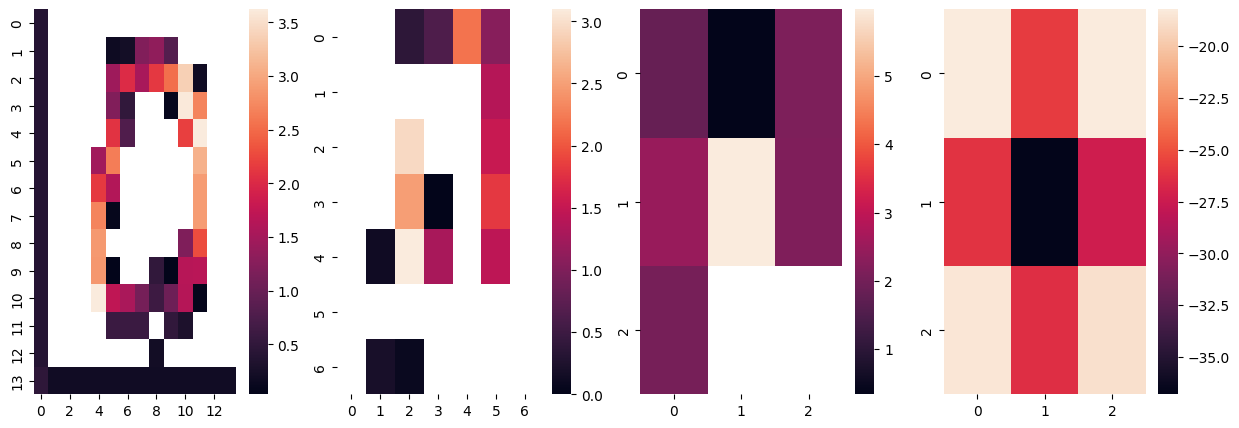

In [3]:
"""
CONV THRESHOLD 1.0 POOL THRESHOLD 3

Conv1: 0.0
Conv2: 0.0020459183673469388
Conv3: 0.0
Conv4: 0.0
Accuracy 98.4
"""

fig, axes = plt.subplots(1,4, figsize=(15,5))
for i in range(1,5):
    conv = pickle.load(open(f'embeddings/conv{i}.pkl', 'rb'))
    if i != 4:
        sns.heatmap(conv[10,10], ax=axes[i-1])
    else:
        sns.heatmap(conv[10,-1], ax=axes[i-1])

fig, axes = plt.subplots(1,4, figsize=(15,5))
for i in range(1,5):
    pool = pickle.load(open(f'embeddings/pool{i}.pkl', 'rb'))

    if i != 4:
        sns.heatmap(pool[10,10], ax=axes[i-1])
    else:
        sns.heatmap(pool[10,-1], ax=axes[i-1])


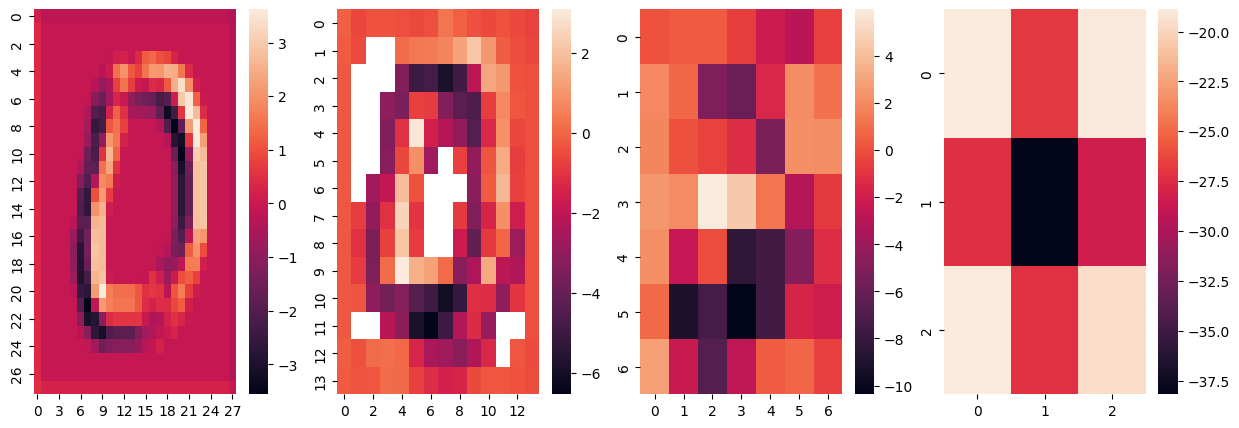

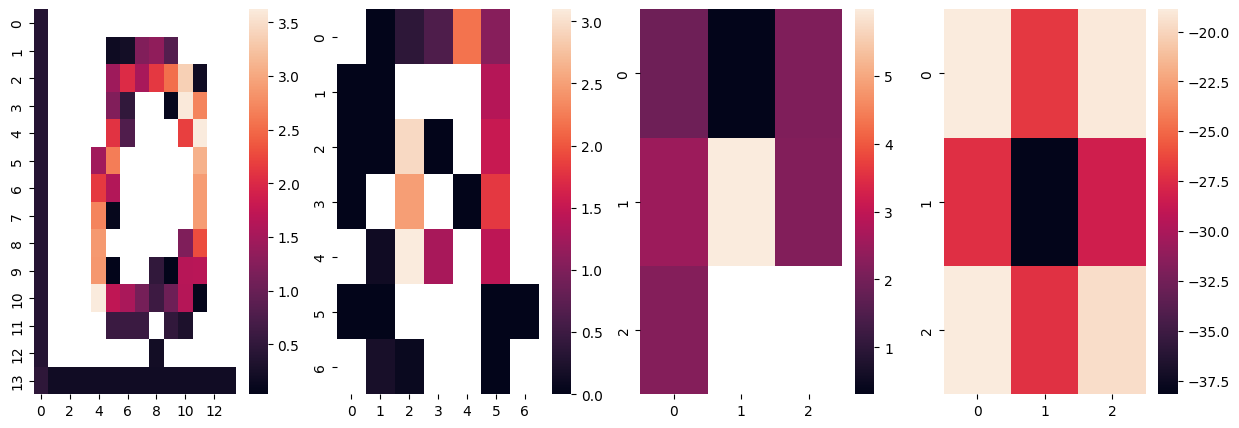

In [8]:
"""
CONV THRESHOLD 0.75 POOL THRESHOLD 3

Conv1: 0.0
Conv2: 0.2760714285714286 54110 196000
Conv3: 0.0014081632653061224
Conv4: 0.0
Accuracy 98.2
"""

fig, axes = plt.subplots(1,4, figsize=(15,5))
for i in range(1,5):
    conv = pickle.load(open(f'embeddings/conv{i}.pkl', 'rb'))
    if i != 4:
        sns.heatmap(conv[10,10], ax=axes[i-1])
    else:
        sns.heatmap(conv[10,-1], ax=axes[i-1])

fig, axes = plt.subplots(1,4, figsize=(15,5))
for i in range(1,5):
    pool = pickle.load(open(f'embeddings/pool{i}.pkl', 'rb'))

    if i != 4:
        sns.heatmap(pool[10,10], ax=axes[i-1])
    else:
        sns.heatmap(pool[10,-1], ax=axes[i-1])


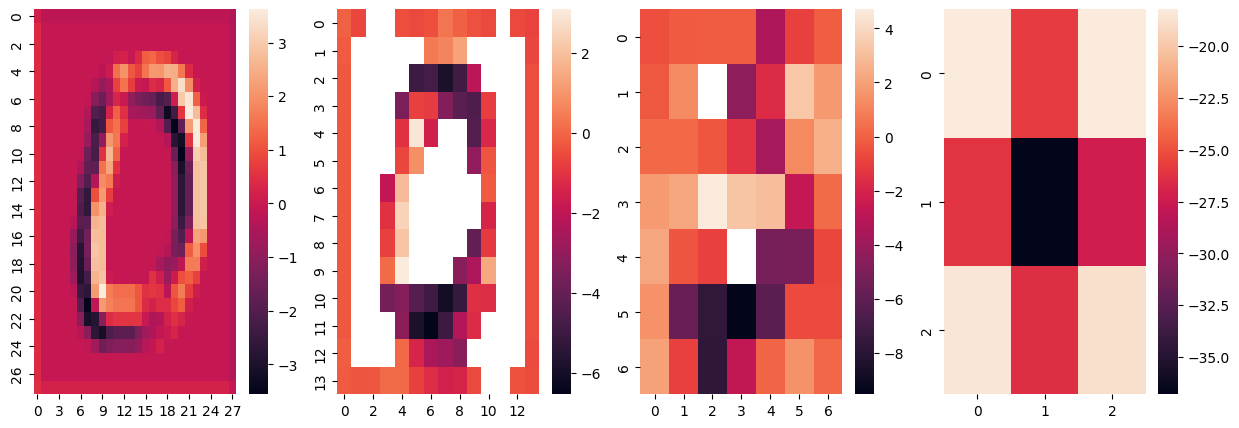

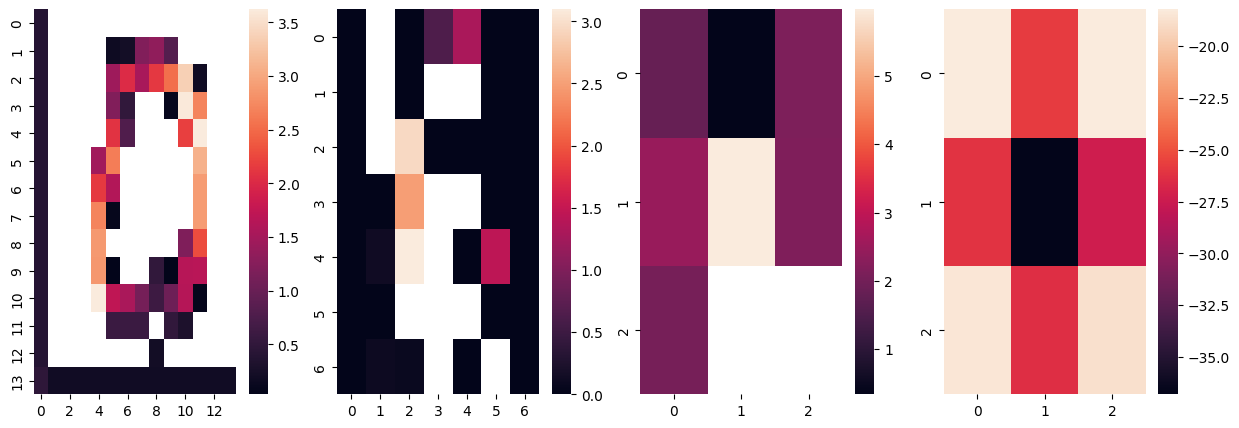

In [ ]:
"""
CONV THRESHOLD 0.5 POOL THRESHOLD 3

Conv1: 0.0
Conv2: 0.5362755102040816
Conv3: 0.14169387755102042
Conv4: 0.0
Accuracy 81.8
"""

fig, axes = plt.subplots(1,4, figsize=(15,5))
for i in range(1,5):
    conv = pickle.load(open(f'embeddings/conv{i}.pkl', 'rb'))
    if i != 4:
        sns.heatmap(conv[10,10], ax=axes[i-1])
    else:
        sns.heatmap(conv[10,-1], ax=axes[i-1])

fig, axes = plt.subplots(1,4, figsize=(15,5))
for i in range(1,5):
    pool = pickle.load(open(f'embeddings/pool{i}.pkl', 'rb'))

    if i != 4:
        sns.heatmap(pool[10,10], ax=axes[i-1])
    else:
        sns.heatmap(pool[10,-1], ax=axes[i-1])


### Pool Threshold 2

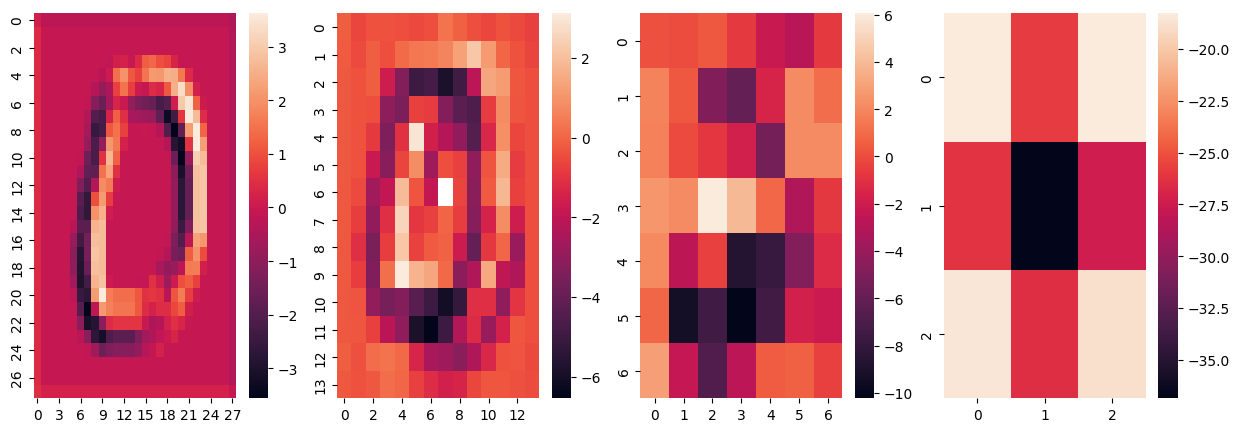

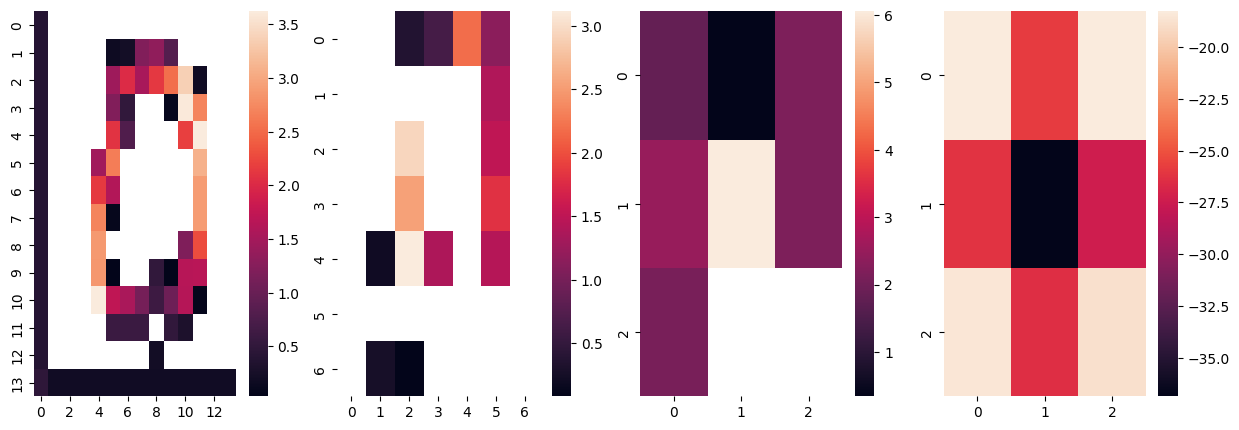

In [6]:
"""
CONV THRESHOLD 1.0 POOL THRESHOLD 2

Conv1: 0.0
Conv2: 0.0632091836734694 12389 196000
Conv3: 0.0
Conv4: 0.0
Accuracy 98.5
"""

fig, axes = plt.subplots(1,4, figsize=(15,5))
for i in range(1,5):
    conv = pickle.load(open(f'embeddings/conv{i}.pkl', 'rb'))
    if i != 4:
        sns.heatmap(conv[10,10], ax=axes[i-1])
    else:
        sns.heatmap(conv[10,-1], ax=axes[i-1])

fig, axes = plt.subplots(1,4, figsize=(15,5))
for i in range(1,5):
    pool = pickle.load(open(f'embeddings/pool{i}.pkl', 'rb'))

    if i != 4:
        sns.heatmap(pool[10,10], ax=axes[i-1])
    else:
        sns.heatmap(pool[10,-1], ax=axes[i-1])


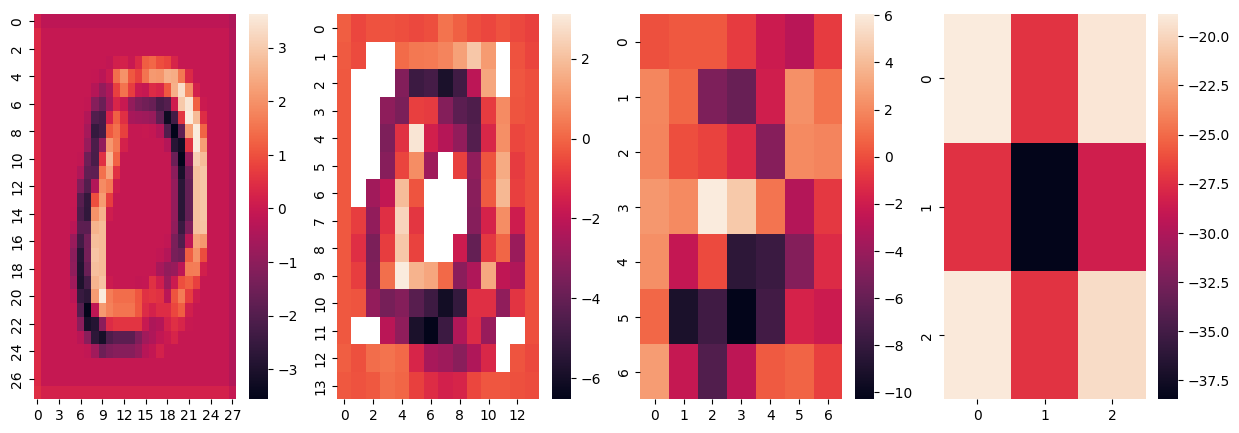

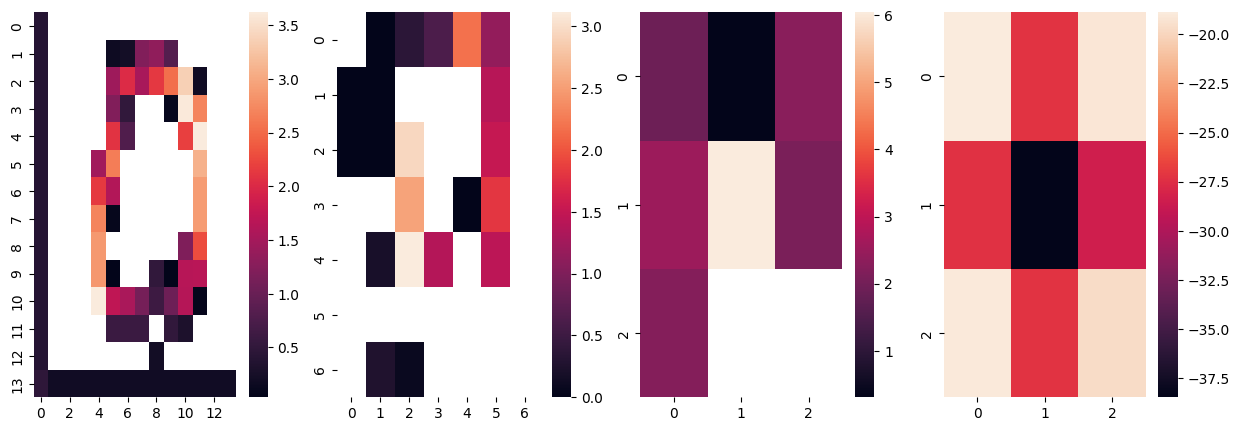

In [7]:
"""
CONV THRESHOLD 0.75 POOL THRESHOLD 2

Conv1: 0.0
Conv2: 0.28290306122448977 
Conv3: 0.0018571428571428571
Conv4: 0.0
Accuracy 98.2
"""

fig, axes = plt.subplots(1,4, figsize=(15,5))
for i in range(1,5):
    conv = pickle.load(open(f'embeddings/conv{i}.pkl', 'rb'))
    if i != 4:
        sns.heatmap(conv[10,10], ax=axes[i-1])
    else:
        sns.heatmap(conv[10,-1], ax=axes[i-1])

fig, axes = plt.subplots(1,4, figsize=(15,5))
for i in range(1,5):
    pool = pickle.load(open(f'embeddings/pool{i}.pkl', 'rb'))

    if i != 4:
        sns.heatmap(pool[10,10], ax=axes[i-1])
    else:
        sns.heatmap(pool[10,-1], ax=axes[i-1])


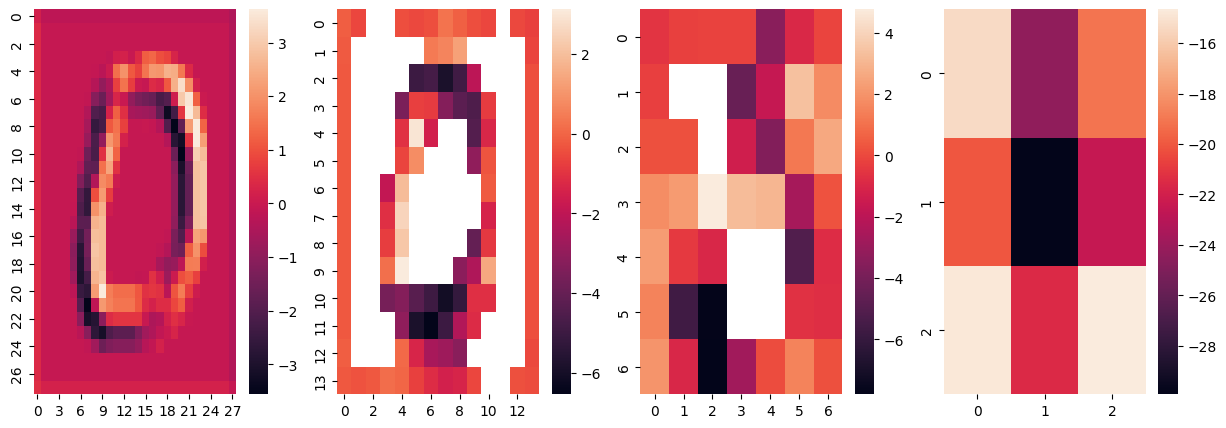

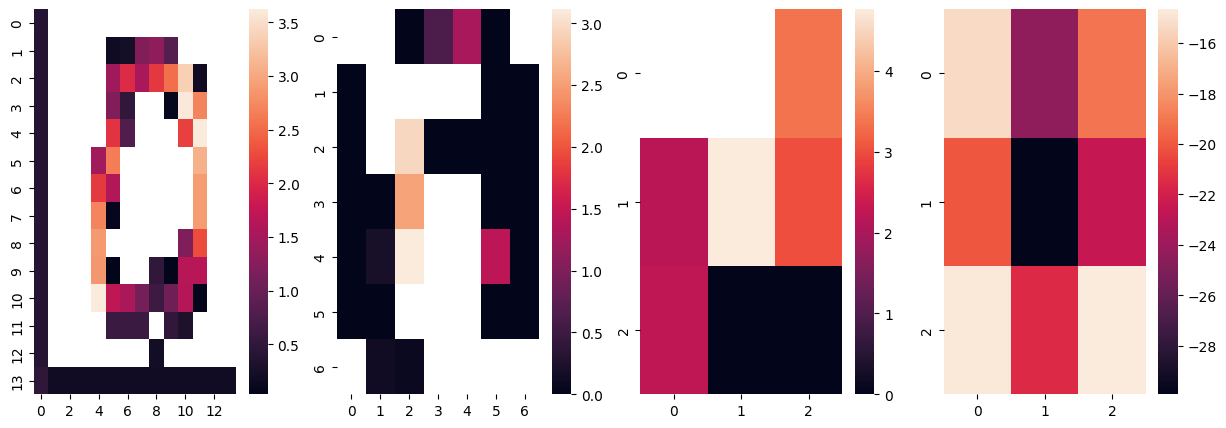

In [ ]:
"""
CONV THRESHOLD 0.5 POOL THRESHOLD 2

Conv1: 0.0
Conv2: 0.5540357142857143
Conv3: 0.3233673469387755
Conv4: 0.028666666666666667
Accuracy 68.89999999999999

"""

fig, axes = plt.subplots(1,4, figsize=(15,5))
for i in range(1,5):
    conv = pickle.load(open(f'embeddings/conv{i}.pkl', 'rb'))
    if i != 4:
        sns.heatmap(conv[10,10], ax=axes[i-1])
    else:
        sns.heatmap(conv[10,-1], ax=axes[i-1])

fig, axes = plt.subplots(1,4, figsize=(15,5))
for i in range(1,5):
    pool = pickle.load(open(f'embeddings/pool{i}.pkl', 'rb'))

    if i != 4:
        sns.heatmap(pool[10,10], ax=axes[i-1])
    else:
        sns.heatmap(pool[10,-1], ax=axes[i-1])


### Pool Threshold 1

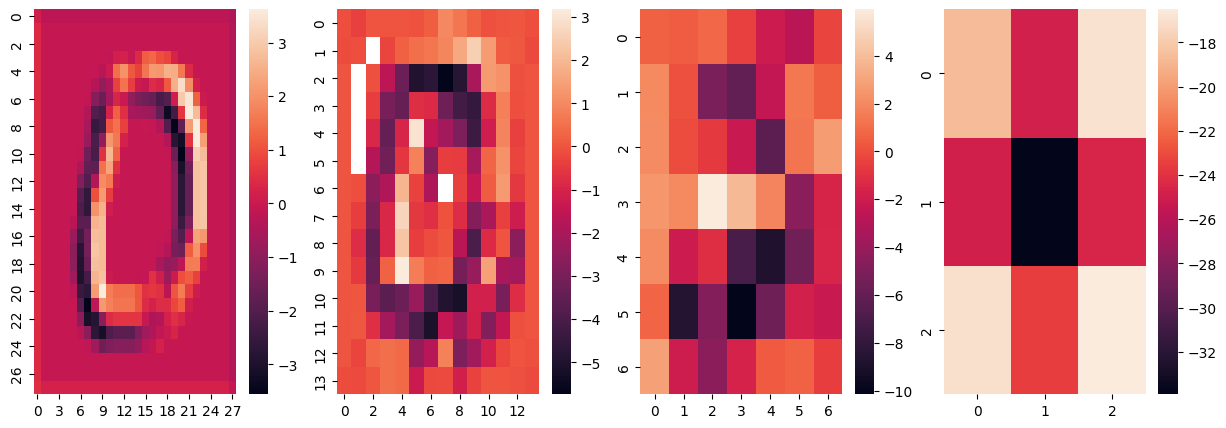

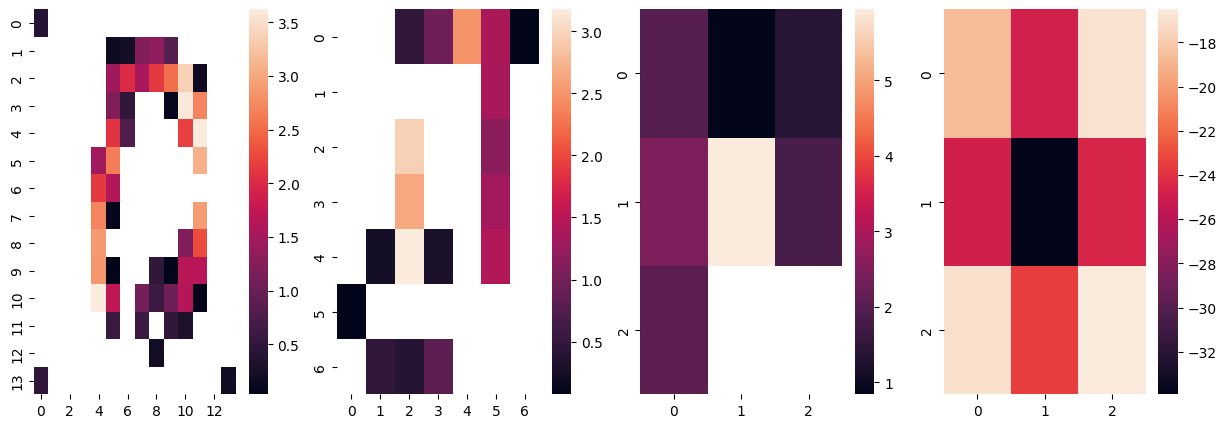

In [4]:
"""
CONV THRESHOLD 1.0 POOL THRESHOLD 1

Conv1: 0.0
Conv2: 0.012908163265306123
Conv3: 0.0
Conv4: 0.0
Accuracy 98.1

"""

fig, axes = plt.subplots(1,4, figsize=(15,5))
for i in range(1,5):
    conv = pickle.load(open(f'embeddings/conv{i}.pkl', 'rb'))
    if i != 4:
        sns.heatmap(conv[10,10], ax=axes[i-1])
    else:
        sns.heatmap(conv[10,-1], ax=axes[i-1])

fig, axes = plt.subplots(1,4, figsize=(15,5))
for i in range(1,5):
    pool = pickle.load(open(f'embeddings/pool{i}.pkl', 'rb'))

    if i != 4:
        sns.heatmap(pool[10,10], ax=axes[i-1])
    else:
        sns.heatmap(pool[10,-1], ax=axes[i-1])


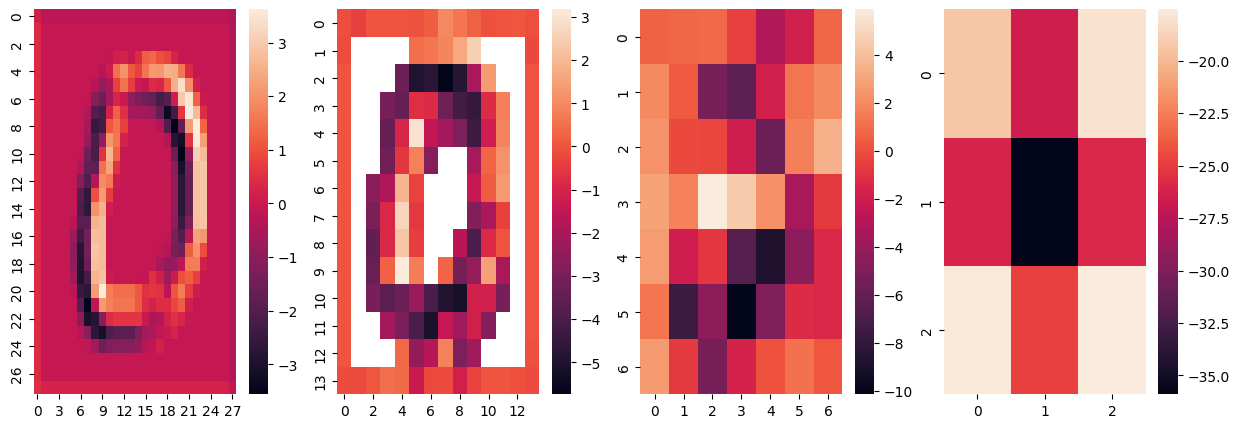

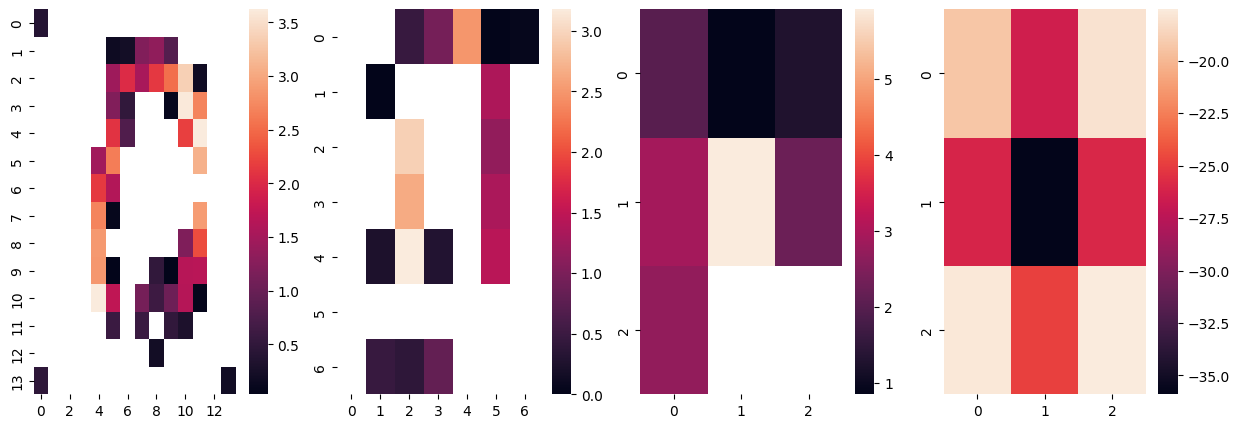

In [9]:
"""
CONV THRESHOLD 0.75 POOL THRESHOLD 1

Conv1: 0.0
Conv2: 0.3638061224489796 71306 196000
Conv3: 0.09257142857142857
Conv4: 0.0
Accuracy 97.5

"""

fig, axes = plt.subplots(1,4, figsize=(15,5))
for i in range(1,5):
    conv = pickle.load(open(f'embeddings/conv{i}.pkl', 'rb'))
    if i != 4:
        sns.heatmap(conv[10,10], ax=axes[i-1])
    else:
        sns.heatmap(conv[10,-1], ax=axes[i-1])

fig, axes = plt.subplots(1,4, figsize=(15,5))
for i in range(1,5):
    pool = pickle.load(open(f'embeddings/pool{i}.pkl', 'rb'))

    if i != 4:
        sns.heatmap(pool[10,10], ax=axes[i-1])
    else:
        sns.heatmap(pool[10,-1], ax=axes[i-1])


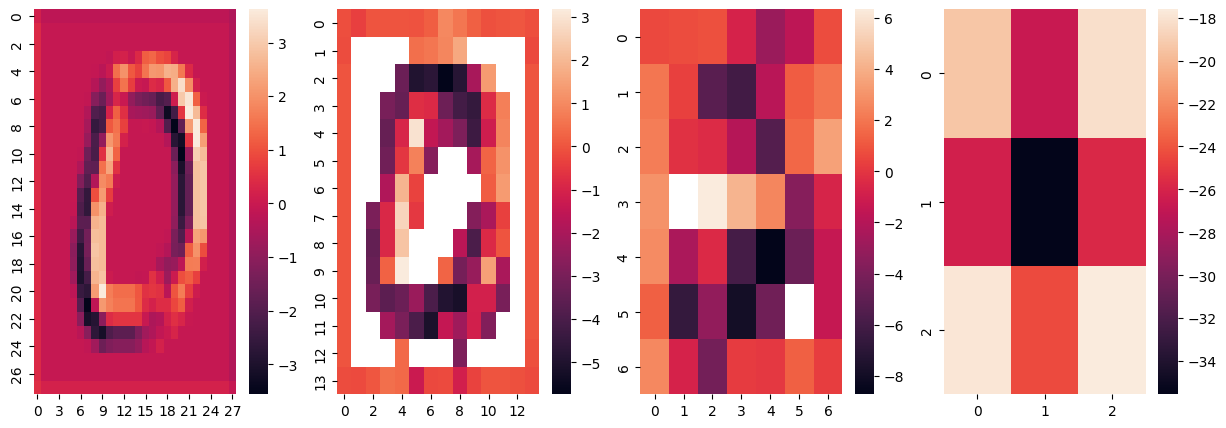

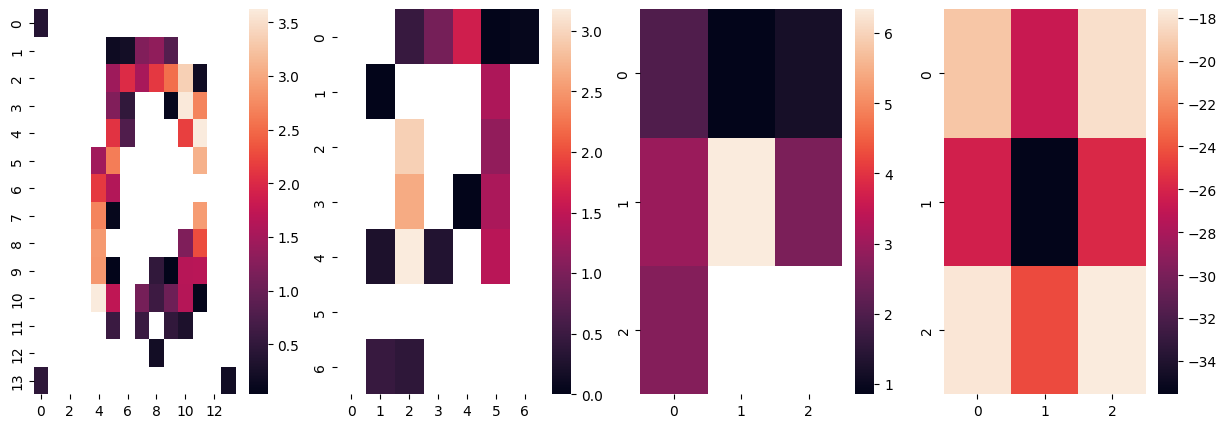

In [11]:
"""
CONV THRESHOLD 0.7 POOL THRESHOLD 1

Conv1: 0.0
Conv2: 0.389265306122449 76296 196000
Conv3: 0.17083673469387756
Conv4: 0.0022222222222222222
Accuracy 95.5

"""

fig, axes = plt.subplots(1,4, figsize=(15,5))
for i in range(1,5):
    conv = pickle.load(open(f'embeddings/conv{i}.pkl', 'rb'))
    if i != 4:
        sns.heatmap(conv[10,10], ax=axes[i-1])
    else:
        sns.heatmap(conv[10,-1], ax=axes[i-1])

fig, axes = plt.subplots(1,4, figsize=(15,5))
for i in range(1,5):
    pool = pickle.load(open(f'embeddings/pool{i}.pkl', 'rb'))

    if i != 4:
        sns.heatmap(pool[10,10], ax=axes[i-1])
    else:
        sns.heatmap(pool[10,-1], ax=axes[i-1])


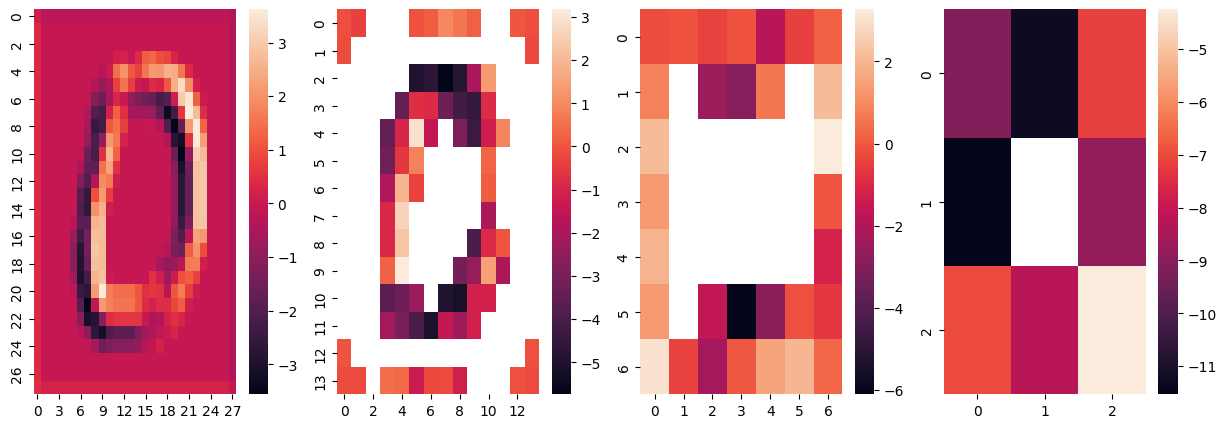

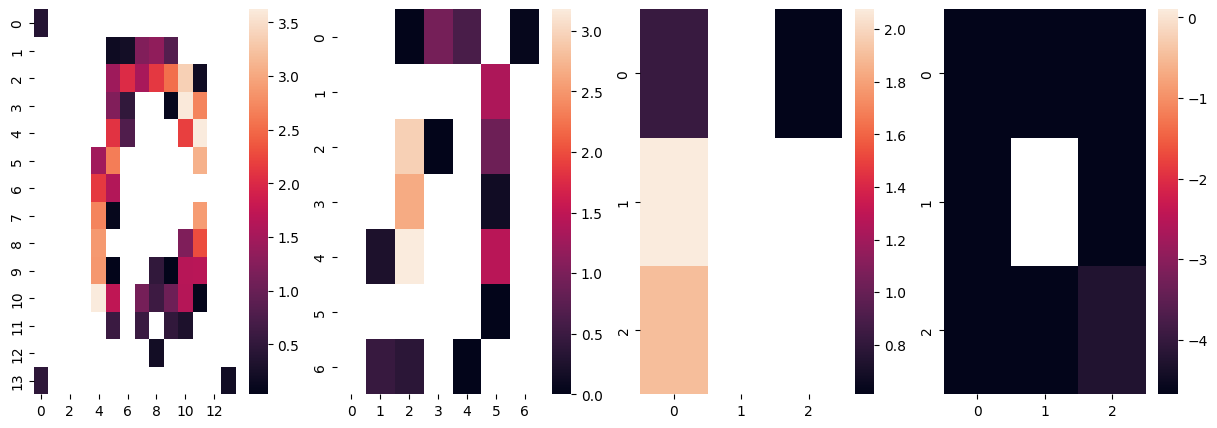

In [10]:
"""
CONV THRESHOLD 0.6 POOL THRESHOLD 1

Conv1: 0.0
Conv2: 0.6192295918367346 121369 196000
Conv3: 0.48191836734693877
Conv4: 0.061
Accuracy 73.1

"""

fig, axes = plt.subplots(1,4, figsize=(15,5))
for i in range(1,5):
    conv = pickle.load(open(f'embeddings/conv{i}.pkl', 'rb'))
    if i != 4:
        sns.heatmap(conv[10,10], ax=axes[i-1])
    else:
        sns.heatmap(conv[10,-1], ax=axes[i-1])

fig, axes = plt.subplots(1,4, figsize=(15,5))
for i in range(1,5):
    pool = pickle.load(open(f'embeddings/pool{i}.pkl', 'rb'))

    if i != 4:
        sns.heatmap(pool[10,10], ax=axes[i-1])
    else:
        sns.heatmap(pool[10,-1], ax=axes[i-1])
